# Baseline for datasets
Insert train.json, test.json under the folder data to get data

In [1]:
from CNN.config import Config
from CNN.utils import WordEmbeddingLoader, RelationLoader, SemEvalDataLoader
import numpy as np
config = Config()
config.batch_size = 1
config.embedding_path = "./CNN/embedding/hlbl-embeddings-scaled.EMBEDDING_SIZE=50.txt"
config.data_dir = "./CNN/data/"
word2id, word_vec = WordEmbeddingLoader(config).load_embedding()
rel2id, id2rel, class_num = RelationLoader(config).get_relation()
loader = SemEvalDataLoader(rel2id, word2id, config)

## Get X and y vectors from dataset
NB: X is already a feature vector got from the word embedding

In [2]:
def get_x_y_from_loader(loader):
    # upload train and test from dataloader
    X = []
    y = []
    for step, (data, label) in enumerate(loader):
        x = data.detach().numpy().flatten()
        x.astype(int)
        X.append(x)
        y.append(label.detach().numpy()[0])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = get_x_y_from_loader(loader.get_train())
X_test, y_test = get_x_y_from_loader(loader.get_test())

## Metrics
According to the [survey](https://link.springer.com/content/pdf/10.1007/s10115-022-01665-w.pdf), the main metrics are Accuracy, Precision, Recall and F1 Score. However, they may generate overoptimistic, misleading results on
imbalanced datasets, as they failed to consider the ratio between positive and negative classes. To mitigate this, Matthews Correlation Coefficient (It is high only when the classifier is doing well in both positive and negative
classes) and G-Mean-Score (a poor performance in positive examples prediction will lead to a low G-mean
value, even if negative instances are correctly classified by the classifier) are used.

In [3]:
from custom_statistics import Statistics
stats = Statistics()
random_states = [0, 1, 42, 100, 5782]

## Baseline: Bayessian Classifier
According to the [survey](https://link.springer.com/content/pdf/10.1007/s10115-022-01665-w.pdf), different baselines are possible. For instance, Logistic Regression, Decision Trees, SVM. [Sorgente et al.](http://ceur-ws.org/Vol-1109/paper4.pdf) used Naive Bayes.

### Naive Bayes

In [4]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
predictions_nb = nb.predict(X_test)
re_nb = stats.get_metrics(predictions_nb, y_test, show=True)

Accuracy Score ->  0.3813029076186971
Precision Score ->  0.7800360837739175
Recall Score ->  0.3813029076186971
F1 Score ->  0.4874455624889103
Matthews Correlation Coefficient ->  0.010199865830754223
G Mean Score ->  0.3518476211430939


#### with train_test_split

In [5]:
from sklearn.model_selection import train_test_split

# train_test_split(X_train, y_train, test_size=0.5, random_state=0, shuffle=False)  for dataset simeval2010
# train_test_split(X_train, y_train, test_size=0.4, random_state=3) for dataset simeval2007
XX_train, XX_test, yy_train, yy_test = train_test_split(X_train, y_train, test_size=0.5, random_state=0, shuffle=False) 
nb.fit(XX_train, yy_train)
predictions_nb_split = nb.predict(X_test)
re_nb_split = stats.get_metrics(predictions_nb_split, y_test, show=True)

Accuracy Score ->  0.513433934486566
Precision Score ->  0.790204176446644
Recall Score ->  0.513433934486566
F1 Score ->  0.6106443344322888
Matthews Correlation Coefficient ->  0.022969428294519315
G Mean Score ->  0.32357454747642866


#### with RepeatedKFold

In [6]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=3)
for train, test in rkf.split(X_train):
    Xx_train, Xx_test = X_train[train], X_train[test]
    Yy_train, Yy_test = y_train[train], y_train[test]
    nb_kf = nb.fit(Xx_train, Yy_train)
predictions_nb_kf = nb_kf.predict(X_test)
re_nb_kf = stats.get_metrics(predictions_nb_kf, y_test, show=True) 

Accuracy Score ->  0.3570114096429886
Precision Score ->  0.7791793240546944
Recall Score ->  0.3570114096429886
F1 Score ->  0.4617462371482742
Matthews Correlation Coefficient ->  0.008193820944631417
G Mean Score ->  0.3516059636074113


## Other possible baselines
### Logistic Regression

In [7]:
import warnings

warnings.filterwarnings('ignore')

stats.clean()
from sklearn.linear_model import LogisticRegression
for random_state in random_states:
    logreg = LogisticRegression(solver='lbfgs', random_state=random_state, multi_class='multinomial', max_iter=100, n_jobs=16)
    logreg.fit(X_train, y_train)
    predictions_logreg = logreg.predict(X_test)
    stats.add(predictions_logreg, y_test)
re_logreg = stats.get_metrics(predictions_logreg, y_test, show=True) 

/Users/lenajd/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lenajd/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Accuracy Score ->  0.8763341921236658
Precision Score ->  0.7728174178602575
Recall Score ->  0.8763341921236658
F1 Score ->  0.8213269458546243
Matthews Correlation Coefficient ->  -0.015306158991591825
G Mean Score ->  0.0


/Users/lenajd/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### with train_test_split

In [8]:
logreg.fit(XX_train, yy_train)
predictions_logreg = logreg.predict(X_test)
re_logreg_split = stats.get_metrics(predictions_logreg, y_test, show=True)

Accuracy Score ->  0.874861980125138
Precision Score ->  0.7818397919017115
Recall Score ->  0.874861980125138
F1 Score ->  0.8220597142036971
Matthews Correlation Coefficient ->  0.012219255185824427
G Mean Score ->  0.0


/Users/lenajd/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### with RepeatedKFold

In [9]:
for train, test in rkf.split(X_train):
    Xx_train, Xx_test = X_train[train], X_train[test]
    Yy_train, Yy_test = y_train[train], y_train[test]
    logreg_kf = logreg.fit(Xx_train, Yy_train)
predictions_logreg_kf = logreg_kf.predict(X_test)
re_logreg_kf = stats.get_metrics(predictions_logreg_kf, y_test, show=True)

/Users/lenajd/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lenajd/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Accuracy Score ->  0.8770702981229297
Precision Score ->  0.7850423750056553
Recall Score ->  0.8770702981229297
F1 Score ->  0.822385919092161
Matthews Correlation Coefficient ->  0.00520016940098953
G Mean Score ->  0.0


### SVM
NB: for large datasets can have a long training period

In [10]:
from sklearn import svm
stats.clean()
for random_state in random_states:
    SVM = svm.SVC(random_state=random_state)
    SVM.fit(X_train, y_train)
    predictions_SVM = SVM.predict(X_test)
    stats.add(predictions_SVM, y_test)
re_SVM = stats.get_metrics(predictions_SVM, y_test, show=True)

Accuracy Score ->  0.8792786161207213
Precision Score ->  0.773130884767171
Recall Score ->  0.8792786161207213
F1 Score ->  0.8227953834361157
Matthews Correlation Coefficient ->  0.0
G Mean Score ->  0.0


#### with train_test_split

In [11]:
SVM.fit(XX_train, yy_train)
predictions_SVM_split = SVM.predict(X_test)
re_SVM_split = stats.get_metrics(predictions_SVM_split, y_test, show=True)

Accuracy Score ->  0.8792786161207213
Precision Score ->  0.773130884767171
Recall Score ->  0.8792786161207213
F1 Score ->  0.8227953834361157
Matthews Correlation Coefficient ->  0.0
G Mean Score ->  0.0


#### with RepeatedKFold

In [12]:
for train, test in rkf.split(X_train):
    Xx_train, Xx_test = X_train[train], X_train[test]
    Yy_train, Yy_test = y_train[train], y_train[test]
    SVM_kf = SVM.fit(Xx_train, Yy_train)
predictions_SVM_kf = SVM_kf.predict(X_test)
re_SVM_kf  = stats.get_metrics(predictions_SVM_kf, y_test, show=True)

Accuracy Score ->  0.8792786161207213
Precision Score ->  0.773130884767171
Recall Score ->  0.8792786161207213
F1 Score ->  0.8227953834361157
Matthews Correlation Coefficient ->  0.0
G Mean Score ->  0.0


### Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier
stats.clean()
for random_state in random_states:
    dtc = DecisionTreeClassifier(random_state=random_state)
    dtc.fit(X_train, y_train)
    predictions_dtc = dtc.predict(X_test)
    stats.add(predictions_dtc, y_test)
re_dt = stats.get_metrics(predictions_dtc, y_test, show=True)

Accuracy Score ->  0.7880014722119986
Precision Score ->  0.8130510758645231
Recall Score ->  0.7880014722119986
F1 Score ->  0.7994814391918025
Matthews Correlation Coefficient ->  0.1474637804946513
G Mean Score ->  0.3262115187476181


#### with train_test_split

In [14]:
dtc.fit(XX_train, yy_train)
predictions_dtc_split = dtc.predict(X_test)
re_dtc_split = stats.get_metrics(predictions_dtc_split, y_test, show=True)

Accuracy Score ->  0.7953625322046375
Precision Score ->  0.8040299207804752
Recall Score ->  0.7953625322046375
F1 Score ->  0.7994873011418726
Matthews Correlation Coefficient ->  0.10553024932924801
G Mean Score ->  0.2902819855342772


#### with RepeatedKFold

In [15]:
for train, test in rkf.split(X_train):
    Xx_train, Xx_test = X_train[train], X_train[test]
    Yy_train, Yy_test = y_train[train], y_train[test]
    dtc_kf = dtc.fit(Xx_train, Yy_train)
predictions_dtc_kf = dtc_kf.predict(X_test)
re_dtc_kf  = stats.get_metrics(predictions_dtc_kf, y_test, show=True)

Accuracy Score ->  0.7681266102318733
Precision Score ->  0.8030432840578112
Recall Score ->  0.7681266102318733
F1 Score ->  0.7842763669079459
Matthews Correlation Coefficient ->  0.10151316796808547
G Mean Score ->  0.29443640873385213


### Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
stats.clean()
for random_state in random_states:
    rfc = RandomForestClassifier(random_state=random_state)
    rfc.fit(X_train, y_train)
    predictions_rfc = rfc.predict(X_test)
    stats.add(predictions_rfc, y_test)
re_rfc = stats.get_metrics(predictions_rfc, y_test, show=True)

Accuracy Score ->  0.8807508281192492
Precision Score ->  0.8949921593722396
Recall Score ->  0.8807508281192492
F1 Score ->  0.82633275194342
Matthews Correlation Coefficient ->  0.10575525811002594
G Mean Score ->  0.04868609125904858


#### with train_test_split

In [17]:
rfc.fit(XX_train, yy_train)
predictions_rfc_split = rfc.predict(X_test)
re_rfc_split = stats.get_metrics(predictions_rfc_split, y_test, show=True)

Accuracy Score ->  0.8803827751196173
Precision Score ->  0.8475988502984035
Recall Score ->  0.8803827751196173
F1 Score ->  0.8268191410149717
Matthews Correlation Coefficient ->  0.09581650053757275
G Mean Score ->  0.0535710194179873


#### with RepeatedKFold

In [18]:
for train, test in rkf.split(X_train):
    Xx_train, Xx_test = X_train[train], X_train[test]
    Yy_train, Yy_test = y_train[train], y_train[test]
    rfc_kf = rfc.fit(Xx_train, Yy_train)
predictions_rfc_kf = rfc_kf.predict(X_test)
re_rfc_kf  = stats.get_metrics(predictions_rfc_kf, y_test, show=True)

Accuracy Score ->  0.8811188811188811
Precision Score ->  0.895277657445799
Recall Score ->  0.8811188811188811
F1 Score ->  0.8271932969093558
Matthews Correlation Coefficient ->  0.11833024493394417
G Mean Score ->  0.05358597712347433


In [19]:
import matplotlib.pyplot as plt
import pandas as pd

re1 = pd.DataFrame(re_nb, columns=['Naive Bayes'],
                 index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
l1 = pd.DataFrame(re_nb_split, 
                 index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
re1['Naive Bayes with train_test_split'] = l1
l2 = pd.DataFrame(re_nb_kf, 
                 index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
re1['Naive Bayes with RepeatedKFold'] = l2
re1

,Naive Bayes,Naive Bayes with train_test_split,Naive Bayes with RepeatedKFold
Accuracy Score,0.381303,0.513434,0.357011
Precision Score,0.780036,0.790204,0.779179
Recall Score,0.381303,0.513434,0.357011
F1 Score,0.487446,0.610644,0.461746
Matthews Correlation Coefficient,0.010200,0.022969,0.008194
G Mean Score,0.351848,0.323575,0.351606


In [20]:
re2 = pd.DataFrame(re_logreg, columns=['Logistic Regression'], 
                   index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
l3 = pd.DataFrame(re_logreg_split, 
                  index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
re2['Logistic Regression with train_test_split'] = l3
l4 = pd.DataFrame(re_logreg_kf, 
                  index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
re2['Logistic Regression with RepeatedKFold'] = l4
re2

,Logistic Regression,Logistic Regression with train_test_split,Logistic Regression with RepeatedKFold
Accuracy Score,0.876334,0.874862,0.877070
Precision Score,0.772817,0.781840,0.785042
Recall Score,0.876334,0.874862,0.877070
F1 Score,0.821327,0.822060,0.822386
Matthews Correlation Coefficient,-0.015306,0.012219,0.005200
G Mean Score,0.000000,0.000000,0.000000


In [21]:
re3 = pd.DataFrame(re_SVM, columns=['SVM'], 
                  index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
re3['SVM with train_test_split'] = pd.DataFrame(re_SVM_split, 
                                                index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                       'Matthews Correlation Coefficient', 'G Mean Score'])
re3['SVM with RepeatedKFold'] = pd.DataFrame(re_SVM_kf, 
                                             index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                    'Matthews Correlation Coefficient', 'G Mean Score'])
re3

,SVM,SVM with train_test_split,SVM with RepeatedKFold
Accuracy Score,0.879279,0.879279,0.879279
Precision Score,0.773131,0.773131,0.773131
Recall Score,0.879279,0.879279,0.879279
F1 Score,0.822795,0.822795,0.822795
Matthews Correlation Coefficient,0.000000,0.000000,0.000000
G Mean Score,0.000000,0.000000,0.000000


In [22]:
re4 = pd.DataFrame(re_dt, columns=['Decision Tree'], 
                   index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                    'Matthews Correlation Coefficient', 'G Mean Score'])
re4['Decision Tree with train_test_split'] = pd.DataFrame(re_dtc_split, 
                                                        index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                    'Matthews Correlation Coefficient', 'G Mean Score'])
re4['Decision Tree with RepeatedKFold'] = pd.DataFrame(re_dtc_kf, 
                                                        index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                    'Matthews Correlation Coefficient', 'G Mean Score'])
re4

,Decision Tree,Decision Tree with train_test_split,Decision Tree with RepeatedKFold
Accuracy Score,0.788001,0.795363,0.768127
Precision Score,0.813051,0.804030,0.803043
Recall Score,0.788001,0.795363,0.768127
F1 Score,0.799481,0.799487,0.784276
Matthews Correlation Coefficient,0.147464,0.105530,0.101513
G Mean Score,0.326212,0.290282,0.294436


In [23]:
re5 = pd.DataFrame(re_rfc, columns=['Random Forest'], 
                   index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
re5['Random Forest with train_test_split'] = pd.DataFrame(re_rfc_split, 
                                                         index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                                'Matthews Correlation Coefficient', 'G Mean Score'])
re5['Random Forest with RepeatedKFold'] = pd.DataFrame(re_rfc_kf, 
                                                     index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                                'Matthews Correlation Coefficient', 'G Mean Score'])
re5

,Random Forest,Random Forest with train_test_split,Random Forest with RepeatedKFold
Accuracy Score,0.880751,0.880383,0.881119
Precision Score,0.894992,0.847599,0.895278
Recall Score,0.880751,0.880383,0.881119
F1 Score,0.826333,0.826819,0.827193
Matthews Correlation Coefficient,0.105755,0.095817,0.118330
G Mean Score,0.048686,0.053571,0.053586


<IPython.core.display.Javascript object>


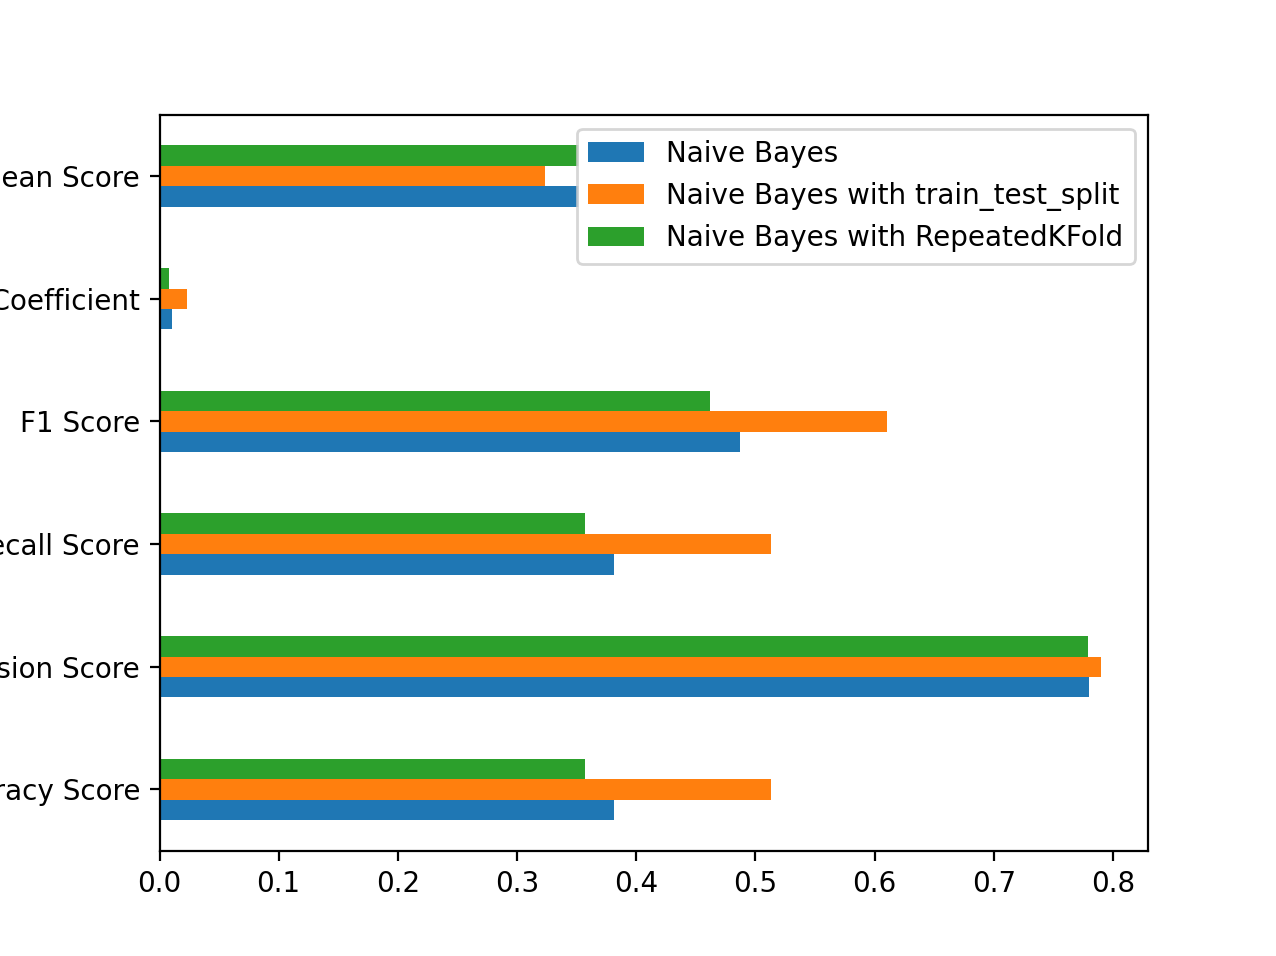

In [31]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

ax=re1.plot(kind='barh')
fig = ax.get_figure()
fig.savefig('Naive Bayes.png', bbox_inches='tight')

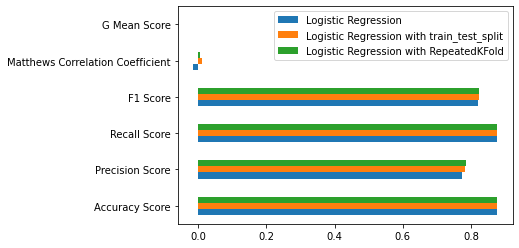

In [25]:
ax=re2.plot(kind='barh')
fig = ax.get_figure()
fig.savefig('Logistic Regression.png', bbox_inches='tight')

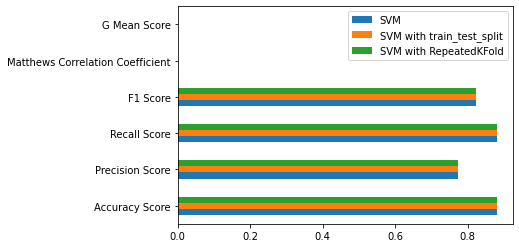

In [26]:
ax=re3.plot(kind='barh')
fig = ax.get_figure()
fig.savefig('SVM.png', bbox_inches='tight')

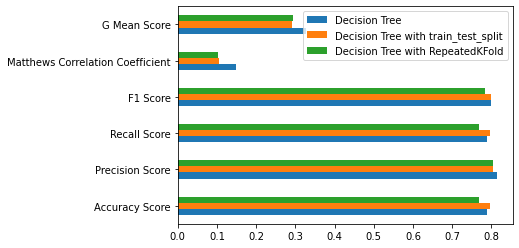

In [27]:
ax=re4.plot(kind='barh')
fig = ax.get_figure()
fig.savefig('Decision Tree', bbox_inches='tight')

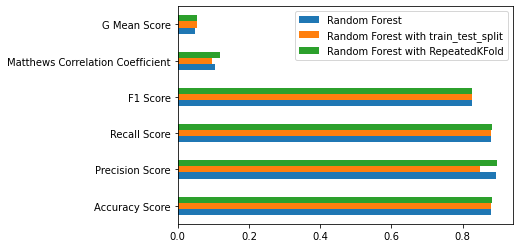

In [28]:
ax=re5.plot(kind='barh')
fig = ax.get_figure()
fig.savefig('Random Forest', bbox_inches='tight')

## Conclusion